In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
GOOD_REVIEW_THRESHOLD = 7

In [4]:
VAL_FRACTION = 0.25

## GET DATA

In [5]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [6]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [7]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '328866',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/N0hCcxXw8d7vUjKfsYO6vg__thumb/img/K4DDlRzl6qlQf9L_oMLb7g9WUYo=/fit-in/200x150/filters:strip_icc()/pic6121929.png',
  'name': "My Father's Work",
  'yearpublished': '2021'},
 {'id': '316090',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/-KMXyStWyla5jh_BRO803w__thumb/img/3j7TG-J5bxigP1RaTbNnHcHnr6A=/fit-in/200x150/filters:strip_icc()/pic6074555.png',
  'name': 'Vivid Memories',
  'yearpublished': '2021'}]

In [8]:
comments_df = get_comments(hot_array, verbose=10)

page number = 10 (max: 100, len: 25)
page number = 20 (max: 100, len: 14)
page number = 30 (max: 100, len: 12)
page number = 40 (max: 100, len: 9)
page number = 50 (max: 100, len: 5)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 4)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (92523, 4)


In [9]:
comments_df

,id,username,rating,value
0,328866,4tsawicki,N/A,Feb 2022
1,328866,alexbatbee,N/A,KS
2,328866,Amekins,N/A,Backer # 1267 on Kickstarter 4/27/2021 Funded ...
3,328866,basstoneslap,N/A,Kickstarter (February 2022)
4,328866,bigduff,N/A,Pre-ordered on Origames web store
...,...,...,...,...
92518,167791,z_zadar,9,Some games are so much fun. Others can be a li...
92519,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
92520,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
92521,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


In [10]:
comments_df.to_csv("comments_20210430.csv", index=False)

In [11]:
# comments_df = pd.read_csv("comments_20210430.csv")

## SPLIT RATED AND NON-RATED COMMENTS

In [12]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

N/A        21532
10         14068
9          13832
8          12606
7           7531
           ...  
9.62           1
8.0981         1
9.02667        1
8.125          1
2.3            1
Name: rating, Length: 532, dtype: int64

In [13]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(70991, 4)

In [14]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(21532, 4)

## CREATE TRAINING AND VALIDATION DATA

In [15]:
# use rated comments (reviews) to train the model

In [16]:
rated_comments = rated_comments.sample(frac=1)

In [17]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [18]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Est. Delivery: same as [url=https://boardgamegeek.com/boardgame/295947/cascadia]Cascadia[/url]'

In [19]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Quite a good, fast and simple play. Usually taking 30 min for a 4 player or 45 min for a 5 player game. I feel 5 player games are even better than 4 player games, they have your brain breaking so much harder.'

In [20]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [21]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.09414469,  0.02249247,  0.11092555, -0.09579244,  0.08374991,
        -0.17683713,  0.27141762,  0.11840045, -0.05403376,  0.21548723,
        -0.10046981,  0.08748468,  0.24914587, -0.05109785, -0.0106999 ,
        -0.04837707,  0.08669894,  0.30512282, -0.09751954, -0.04456562,
        -0.17053202,  0.0156113 ,  0.08767512, -0.2575577 , -0.1055233 ,
        -0.14089775, -0.16710137, -0.17266317,  0.10121128, -0.04590312,
        -0.21882223, -0.01380192, -0.04548811, -0.04838876,  0.04670456,
         0.19151159,  0.1770601 ,  0.01022145,  0.02043806, -0.19791529,
         0.08778028, -0.14890468, -0.09357993, -0.07401755, -0.02985918,
        -0.1673463 , -0.14861302,  0.0613607 , -0.20998506,  0.08609507],
       [ 0.6169365 , -0.09345467, -0.18527608,  0.10304804,  0.23821594,
         0.10421059, -0.07704309,  0.18209526, -0.28951797,  0.13467476,
         0.36217448,  0.3342662 ,  0.25578237,  0.1311492 , -0.32087186,
 

In [22]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [24]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2
)

Train on 53244 samples, validate on 17747 samples
Epoch 1/40
53244/53244 - 32s - loss: 0.4602 - accuracy: 0.8430 - val_loss: 0.3765 - val_accuracy: 0.8485
Epoch 2/40
53244/53244 - 32s - loss: 0.3274 - accuracy: 0.8692 - val_loss: 0.3266 - val_accuracy: 0.8697
Epoch 3/40
53244/53244 - 32s - loss: 0.2718 - accuracy: 0.8911 - val_loss: 0.3199 - val_accuracy: 0.8721
Epoch 4/40
53244/53244 - 31s - loss: 0.2361 - accuracy: 0.9064 - val_loss: 0.3282 - val_accuracy: 0.8692
Epoch 5/40
53244/53244 - 32s - loss: 0.2101 - accuracy: 0.9178 - val_loss: 0.3485 - val_accuracy: 0.8665
Epoch 6/40
53244/53244 - 32s - loss: 0.1896 - accuracy: 0.9277 - val_loss: 0.3715 - val_accuracy: 0.8623
Epoch 7/40
53244/53244 - 32s - loss: 0.1737 - accuracy: 0.9349 - val_loss: 0.3961 - val_accuracy: 0.8576
Epoch 8/40
53244/53244 - 32s - loss: 0.1598 - accuracy: 0.9401 - val_loss: 0.4252 - val_accuracy: 0.8546
Epoch 9/40
53244/53244 - 32s - loss: 0.1489 - accuracy: 0.9449 - val_loss: 0.4471 - val_accuracy: 0.8465
Epoch

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [27]:
epochs = range(1, len(acc) + 1) 

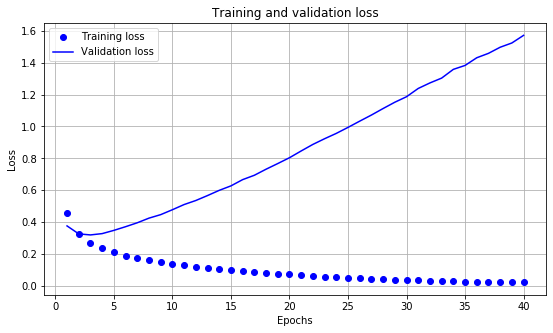

In [28]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

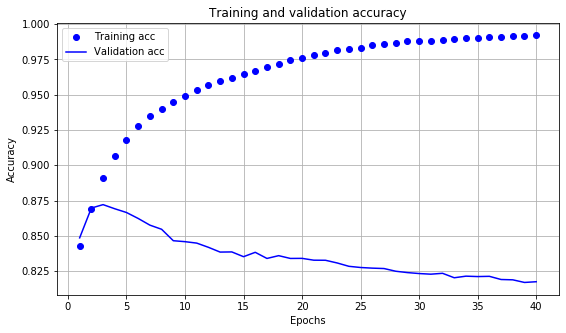

In [29]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [30]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [33]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Outstanding. Always want to play and expect this will never change.   I now understand why people get addicted to gambling. Every round is exhilarating. Just one more time!  No one ever feels like they're losing and there is the constant feeling of instant gratification. Most games you build up to do an awesome turn, this one just gives it to you just for existing"
score: 1.000000
actual value:1

input:
"Liked it, but am not in love with it."
score: 0.984914
actual value:1

input:
"Our family and EVERYONE we intro to this love this game.  I’ve played it over 100 times. Perfect for travel as packs really small"
score: 0.999999
actual value:1

input:
"Wingspan improves on the engine building model and makes a game full of strategy without any slog. It's also amazing to look at."
score: 1.000000
actual value:1

input:
"First game was a bit rough.  Lots of little rules to remember, but after my 3rd play, I really started getting into it.  It is very combo-rific and you feel good wh

In [35]:
## APPLY MODEL ON NON-RATED COMMENTS

In [36]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Kickstarter"
score: 0.944020

input:
"Plays 1-5"
score: 0.999864

input:
"not the $130 they are asking...."
score: 0.999963

input:
"KS during the expansion campaign."
score: 0.904124

input:
"✔️"
score: 0.439714

input:
"Print and play version!  Would like a more permanent set eventually."
score: 0.999802

input:
"KS EDITION"
score: 0.894193

input:
"Fighting alien monsters. You get to choose if you play nice or if you can betray each other."
score: 1.000000

input:
"KS"
score: 0.996206

input:
"3/4"
score: 0.983456

input:
"+ Book of the Dead + The Great Old Ones"
score: 0.007308

input:
"80"
score: 0.855181

input:
"Needs 1 more play."
score: 0.999805

input:
"[b]Expansiones[/b]  On Mars: Beacon Promo Card (Spanish edition) (2020)   On Mars: Upgrade Pack (2020)  "
score: 1.000000

input:
"1-4 Players Worker placement Deck building"
score: 0.999998

input:
"See"
score: 0.878356

input:
"1-5 players"
score: 0.994348

input:
"not played yet"
score: 0.957674

input:
"Fantasywelt

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [37]:
rated_comments.head()

,id,username,rating,value
19182,283155,nifdgad,8,Est. Delivery: same as [url=https://boardgameg...
65615,148228,Isaac_Llopis,6,"Quite a good, fast and simple play. Usually ta..."
26039,205637,couchoud,8,"I like the game, but not nearly enough to buy ..."
33648,193738,fifizi,9,Great game. Love the theme so much that it's a...
16221,256960,ibn_ul_khattab,9,This has been a real hit with my group. It is ...


In [38]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,148228,7.382082,7283
1,162886,8.352335,3468
2,163068,7.764993,938
3,167355,8.419538,1770
4,167791,8.212217,8193


In [39]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [40]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,148228,8.483615,1477
1,162886,8.693542,1022
2,163068,8.964352,432
3,167355,8.656996,679
4,167791,8.591240,1621


In [63]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [64]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,148228,7.382082,7283,8.483615,1477,31,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014,https://boardgamegeek.com/boardgame/148228
1,162886,8.352335,3468,8.693542,1022,10,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886
2,163068,7.764993,938,8.964352,432,37,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015,https://boardgamegeek.com/boardgame/163068
3,167355,8.419538,1770,8.656996,679,24,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355
4,167791,8.212217,8193,8.591240,1621,13,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791


In [66]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [67]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,148228,7.382082,7283,8.483615,1477,31,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014,https://boardgamegeek.com/boardgame/148228,7.567809
1,162886,8.352335,3468,8.693542,1022,10,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886,8.429999
2,163068,7.764993,938,8.964352,432,37,https://cf.geekdo-images.com/9gob752VqEklQFV_g...,Trickerion: Legends of Illusion,2015,https://boardgamegeek.com/boardgame/163068,8.143185
3,167355,8.419538,1770,8.656996,679,24,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355,8.485374
4,167791,8.212217,8193,8.591240,1621,13,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,Terraforming Mars,2016,https://boardgamegeek.com/boardgame/167791,8.274821


In [68]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished', 'url']]

In [90]:
def path_to_image_html(path):
    return f'<img src="{path}" width="124" />'

def path_to_url_html(url):
    return f'<a href="{url}">link</a>'

In [91]:
# TOP 5 RANK
HTML(grouped.sort_values('rank').head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
45,,My Father's Work,5.375000,8.650000,8.264706,1,2021,link
38,,Vivid Memories,7.500000,7.900000,7.785714,2,2021,link
37,,Lost Ruins of Arnak,7.938240,8.811417,8.197035,3,2020,link
30,,Oath: Chronicles of Empire and Exile,7.947037,9.039300,8.716110,4,2021,link
39,,Dune: Imperium,8.119612,8.698174,8.270811,5,2020,link


In [92]:
# TOP 5 REVIEW RANK
HTML(grouped.sort_values('rating_mean_review', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
40,,Stationfall,9.375000,9.962500,9.668750,17,2021,link
32,,Kemet: Blood and Sand,8.833333,8.882967,8.877833,35,2021,link
19,,Eclipse: Second Dawn for the Galaxy,8.737280,8.764807,8.747042,42,2020,link
15,,Brass: Birmingham,8.687554,8.623333,8.669158,21,2018,link
29,,Gloomhaven: Jaws of the Lion,8.622333,8.588462,8.613005,19,2020,link


In [93]:
# TOP 5 FIXED RANK
HTML(grouped.sort_values('fixed_rating', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
40,,Stationfall,9.375000,9.962500,9.668750,17,2021,link
32,,Kemet: Blood and Sand,8.833333,8.882967,8.877833,35,2021,link
28,,Zombicide (2nd Edition),7.625000,9.357500,8.862500,36,2021,link
47,,Brew,6.600000,10.000000,8.785714,27,2021,link
19,,Eclipse: Second Dawn for the Galaxy,8.737280,8.764807,8.747042,42,2020,link


In [85]:
model.save('saved_model\my_model')

INFO:tensorflow:Assets written to: saved_model\my_model\assets


INFO:tensorflow:Assets written to: saved_model\my_model\assets


In [57]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [58]:
# some examples on "long" comments vs short comments

In [59]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [60]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Check it out (Monique and Naveen have a playthrough). Cards played through the game do things for you, but also the cards you have at the end matter, getting combinations and interactions between them. I think."
score: 0.070860

input:
"surprisingly elegant considering its pedigree. creates some great tension and deckbuilding is good if you buy two copies of base game. but it had to go because i didn't want to go down the rabbit hole of never ending expansions..."
score: 1.000000

input:
"I like cooperative dungeon crawlers but I am not sure that Gloomhaven's combat will appeal to me. At $40, I am risking much less trying it."
score: 0.000579

input:
"Vollständig enthalten in Kickstarter-Edition.  Genauen Inhalt und vollständige Liste siehe Kickstarter-Edition!"
score: 1.000000

input:
"KS, 1/22/18, with the Medic add-on.  Couldn't pass it up, sounds very well-developed, replayable and atmospheric.  Saw a movie something like this once."
score: 1.000000

input:
"P: 1-4, T: 90-1